In [1]:
# magic command for automatic reload of python modules without needing to restart the notebook
%load_ext autoreload
%autoreload 2

In [75]:
import numpy as np
import scipy as sc
import tensorflow as tf
import tensorflow_probability as tfp
tfd=tfp.distributions
tfb=tfp.bijectors
from scipy import io
import time
import matplotlib.pyplot as plt
from sklearn import mixture
import joblib as jbl
import sys
import sklearn
import pandas as pd
from mixture_models import GMCM, GMC
import utils as utl

Number of samples = 150, Number of dimensions = 4
Learning Marginals
Marginals learnt in 1.54 s.
@ Iter:0,                         Training error: -10.5,                         Validation error: nan,                         Time Elapsed: 4.9 s
@ Iter:500,                         Training error: -12.8,                         Validation error: nan,                         Time Elapsed: 8.5 s
@ Iter:1000,                         Training error: -13.3,                         Validation error: nan,                         Time Elapsed: 12.1 s
@ Iter:1500,                         Training error: -13.1,                         Validation error: nan,                         Time Elapsed: 15.8 s
@ Iter:2000,                         Training error: -13.3,                         Validation error: nan,                         Time Elapsed: 19.6 s
@ Iter:2500,                         Training error: -13.2,                         Validation error: nan,                         Time Elapsed: 23.5

Text(0, 0.5, 'neg. log-likelihood')

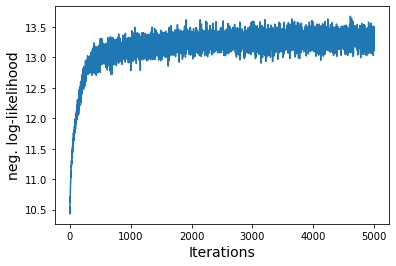

In [104]:
# Example learning GMMC on Iris dataset
from sklearn.datasets import load_iris

data=load_iris().data.astype('float32')
nsamps,ndims = data.shape


# Defining a preprocessing bijective transform (eg, log transform in this case)  
min_val = (np.min(data)-3*np.std(data)).astype('float32')
log_transform = tfb.Chain([tfb.Shift(shift=min_val),tfb.Exp()])


data_trn,data_vld,data_tst = utl.splitData(data)

# data_in = data.astype('float32')
nsamps,ndims = data.shape
print(f'Number of samples = {nsamps}, Number of dimensions = {ndims}')

# Initialing GMCM object
gmcm_obj=GMCM(ndims, data_transform=log_transform)
# Train GMCM
nll_train,nll_vld,_=gmcm_obj.fit_dist_IFM(data_trn,
                                    n_comps=2,
                                    batch_size=50,
                                    max_iters=5000,
                                    regularize=True, 
                                    print_interval=500)

# plots log-likelihood
plt.plot(-nll_train)
plt.xlabel('Iterations',fontsize=14)
plt.ylabel('neg. log-likelihood',fontsize=14)

Text(0.5, 1.0, 'GMCM density contours')

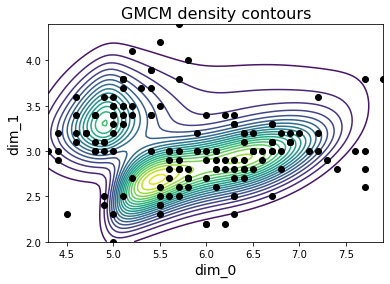

In [108]:
# PLOTTING THE DENSITY CONTOURS OF LEARNED GMCM
mins=np.min(data,axis=0)
maxs=np.max(data,axis=0)

# specfying the dimension for density plotting
dim1,dim2=0,1
# obtaining the marginal GMCM
marg_gmcm=gmcm_obj.get_marginal([dim1,dim2])
# specifying the gridsie for density plotting
ngrid=100
X,Y=np.meshgrid(np.linspace(mins[dim1],maxs[dim1],ngrid),(np.linspace(mins[dim2],maxs[dim2],ngrid)))
X=X.astype('float32')
Y=Y.astype('float32')
z=np.concatenate([X.reshape(-1,1),Y.reshape(-1,1)],axis=1)
# computing the GMCM density values
prob_z=np.exp(marg_gmcm.distribution.log_prob(z).numpy())
# reshaping the density vector
Z=prob_z.reshape(ngrid,ngrid)
# Plotting the density contours along with the  data
plt.contour(X,Y,Z,20)
plt.plot(data[:,dim1],data[:,dim2],'ko')
plt.xlabel(f'dim_{dim1}',fontsize=14)
plt.ylabel(f'dim_{dim2}',fontsize=14)
plt.title('GMCM density contours',fontsize=16)